# Software Effort Estimation Using LLMs

This research work aims to check and evaluate the performance of GPT-4 and LLAMA-3 towards software effort estimation in a zero shot setting and a trained setting.

# Data Exploration

In [38]:
# install libraries
!pip3 install pandas
!pip3 install numpy
!pip3 install matplotlib
!pip3 install wordcloud
!pip3 install seaborn
!pip3 install nltk
!pip3 install mysql-connector-python


In [39]:
!pip3 freeze > requirements.txt

In [40]:
# import libraries
import mysql.connector
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from collections import Counter
import seaborn as sns
import nltk
import re

In [41]:
# Connect to MySQL
conn = mysql.connector.connect(
    host="localhost",
    user="root",
    password="My-N7w_And.5ecure-P@s5w0rd",
    database="local"
)

In [42]:
# Read table into DataFrame
query = "SELECT * FROM Issue"
df = pd.read_sql(query, conn)

/tmp/ipykernel_217248/1919074633.py:3: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


In [43]:
# Close connection
conn.close()

In [44]:
# check shape
df.shape

(458232, 30)

there are about 450000 rows with 30 columns in the dataframe

In [45]:
# display first few rows of the dataframe
print(df.head())

   ID  Jira_ID Issue_Key                                            URL  \
0  65    77638   XD-3768  https://jira.spring.io/rest/api/2/issue/77638   
1  66    77511   XD-3767  https://jira.spring.io/rest/api/2/issue/77511   
2  67    77130   XD-3766  https://jira.spring.io/rest/api/2/issue/77130   
3  68    71950   XD-3765  https://jira.spring.io/rest/api/2/issue/71950   
4  69    71805   XD-3764  https://jira.spring.io/rest/api/2/issue/71805   

                                               Title  \
0     "How do I make a job restartable in spring xd"   
1      "admin config timezone command does not work"   
2  "Module Upload command not pushing jar to all ...   
3                             "Fix stream failover "   
4  "SpringXD Job is still executing even after fo...   

                                         Description  \
0  "The jobs that appear under Executions section...   
1  "Working with Spring-XD version 1.3.2.RELEASE ...   
2  "My project 7 node cluster and in that 2 

In [46]:
# describe the df
df.describe()

,ID,Jira_ID,Creation_Date,Estimation_Date,Resolution_Date,Last_Updated,Story_Point,Timespent,In_Progress_Minutes,Total_Effort_Minutes,Resolution_Time_Minutes,Title_Changed_After_Estimation,Description_Changed_After_Estimation,Story_Point_Changed_After_Estimation,Creator_ID,Reporter_ID,Assignee_ID,Project_ID,Sprint_ID
count,458232.000000,4.582320e+05,458232,65427,352632,458232,6.542700e+04,10243.000000,4.582320e+05,4.582320e+05,4.582320e+05,458232.000000,458232.0,458232.000000,456641.000000,455736.000000,261831.000000,458232.000000,43475.000000
mean,250427.756628,6.842263e+05,2014-04-25 10:20:30.745779968,2016-10-11 02:50:38.484784384,2015-01-17 07:35:58.695246336,2017-10-16 16:03:56.466746368,4.135718e+02,323.090501,5.238023e+03,2.343935e+04,4.084872e+05,0.141330,0.0,0.020068,120547.190712,120825.496105,133827.102066,24.998507,2711.075791
min,65.000000,1.000000e+04,2002-02-08 04:45:00,2004-07-08 10:38:38,2004-02-12 23:48:28,2002-08-04 02:02:50,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.0,0.000000,68.000000,68.000000,71.000000,1.000000,1.000000
25%,114626.750000,5.834075e+04,2011-10-20 09:26:30.500000,2015-02-03 15:20:59.500000,2012-07-19 12:52:00,2016-07-12 00:30:12.750000128,1.000000e+00,46.000000,0.000000e+00,0.000000e+00,4.000000e+00,0.000000,0.0,0.000000,73529.000000,74305.000000,116063.000000,18.000000,1395.500000
50%,229184.500000,1.471675e+05,2014-09-02 12:20:13,2017-01-19 02:10:51,2015-06-09 08:33:02.500000,2018-11-26 12:21:40,3.000000e+00,120.000000,0.000000e+00,0.000000e+00,1.535700e+04,0.000000,0.0,0.000000,145748.000000,145748.000000,151325.000000,23.000000,2941.000000
75%,394473.250000,6.167282e+05,2017-07-22 19:51:16.249999872,2018-09-10 22:02:46.500000,2018-03-27 11:24:24.249999872,2019-09-19 06:46:56,5.000000e+00,300.000000,0.000000e+00,1.458000e+03,2.634485e+05,0.000000,0.0,0.000000,164408.000000,164408.000000,166050.000000,34.000000,4053.000000
max,509035.000000,1.333610e+07,2020-10-23 22:13:07,2020-10-22 14:51:07,2020-10-23 04:53:21,2020-10-24 13:46:06,2.671011e+07,24622.000000,4.771423e+06,4.806555e+06,9.156071e+06,1.000000,0.0,1.000000,209125.000000,209125.000000,208978.000000,44.000000,5027.000000
std,154217.334318,2.121512e+06,NaN,NaN,NaN,NaN,1.044232e+05,761.792096,5.792574e+04,1.286546e+05,8.887023e+05,0.348362,0.0,0.140235,62373.774892,62234.714879,60001.012434,10.805999,1512.380726


In [47]:
# check column names
df.columns

Index(['ID', 'Jira_ID', 'Issue_Key', 'URL', 'Title', 'Description',
       'Description_Text', 'Description_Code', 'Type', 'Priority', 'Status',
       'Resolution', 'Creation_Date', 'Estimation_Date', 'Resolution_Date',
       'Last_Updated', 'Story_Point', 'Timespent', 'In_Progress_Minutes',
       'Total_Effort_Minutes', 'Resolution_Time_Minutes',
       'Title_Changed_After_Estimation',
       'Description_Changed_After_Estimation',
       'Story_Point_Changed_After_Estimation', 'Pull_Request_URL',
       'Creator_ID', 'Reporter_ID', 'Assignee_ID', 'Project_ID', 'Sprint_ID'],
      dtype='object')

In [48]:
# check types
df['Type'].value_counts()

Type
Bug                              215570
Suggestion                        96370
Improvement                       42691
Story                             31394
Task                              28338
Sub-task                          14396
New Feature                       14239
Epic                               4157
Enhancement Request                3239
Support Request                    2368
Build Failure                      1715
Question                           1396
Technical task                      987
Documentation                       699
Test Task                           336
Problem Ticket                      113
Wish                                 88
Milestone                            44
Technical Debt                       30
Investigation                        22
Incident                             18
Test                                 17
Release                               4
Public Security Vulnerability         1
Name: count, dtype: int64

In [49]:
# filter rows with type = 'Story'
df = df[df['Type'] == 'Story']

In [50]:
# check shape
df.shape

(31394, 30)

In [51]:
# extract only useful columns
df = df[['Description','Resolution_Time_Minutes']]

In [52]:
# check shape
df.shape

(31394, 2)

In [53]:
# check few rows
df.sample(10)

,Description,Resolution_Time_Minutes
235444,"""Decide how we document/control the {{DataUnit...",485178.0
223688,"""""""recommended"""" tag resolution is failing aga...",1230.0
248328,"""In order to make the issues of eventual consi...",3611408.0
222296,"""Some maintenance chores now that we've launch...",15602.0
229729,"""The dask labextension makes the logs hard to ...",95279.0
40101,"""Namely... * datetime is replaced by moment.j...",28771.0
232767,"""Currently the SQuaSH REST API conforms to Ope...",0.0
224321,"""For the PFS project, we have issues writing c...",568.0
235488,"""The purpose of this ticket is to request clar...",0.0
239821,"""The {{interact}} method of an afwDisplay.Disp...",0.0


In [54]:
# remove rows with empty descriptions
df = df[df['Description'] != '']

In [55]:
# check shape
df.shape

(27327, 2)

In [56]:
# remove rows with 0 resolution minutes
df = df[df['Resolution_Time_Minutes'] != 0]

In [57]:
# check shape
df.shape

(22459, 2)

In [58]:
# check for null values
df['Description'].isnull().sum()

np.int64(0)

In [59]:
# check for null values
df['Resolution_Time_Minutes'].isnull().sum()

np.int64(0)

In [61]:
# add column for checking length of the descriptions
df['Description_Length'] = df['Description'].apply(lambda x: len(x.split()))

In [62]:
# describe the length column
df['Description_Length'].describe()

count    22459.000000
mean        57.292088
std         97.680646
min          1.000000
25%         19.000000
50%         35.000000
75%         67.000000
max       8374.000000
Name: Description_Length, dtype: float64

the average description length is around 57 characters

In [63]:
# define a function to clean text
def clean_text(text):
    text = text.lower()  # convert to lowercase
    text = re.sub(r'[^\w\s]', '', text)  # remove punctuation and special characters
    return text

In [65]:
# apply clean_text function to descriptions and save to new column
df['Cleaned_Description'] = df['Description'].apply(clean_text)

In [72]:
# check few rows
df['Cleaned_Description'].sample(10)

226879    token grabbed github write scope still configu...
225487    mtaos support logging file realized helpful de...
231678    get mops sims_maf sims_movingobjects solar sys...
216971           fabricexamplesconfigtxupdatereadmemd error
242187    whilst looking individual spot cbp decam notic...
229849    organizational logistical aspects lsst science...
224552    task reprioritized getting server eui installe...
38216     complete documentation survey app developer pr...
233934    convert lsstafwgeoms python numpydoc following...
407942    simple enhancement provides option site admin ...
Name: Cleaned_Description, dtype: object

In [66]:
# download stop words
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /home/udayk/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [67]:
# extract english stop words
stop_words = set(nltk.corpus.stopwords.words('english'))

In [68]:
# define a function to remove stop words
def remove_stopwords(text):
    return ' '.join([word for word in text.split() if word not in stop_words])

In [69]:
# apply remove_stopwords function on cleaned descriptions
df['Cleaned_Description'] = df['Cleaned_Description'].apply(remove_stopwords)

In [73]:
# check few rows
df['Cleaned_Description'].sample(10)

153       currently scs modules come baked support multi...
228774    build files package hardcoded locations packag...
340428    packaged examples modified per following plan ...
222227    complete phishing driving exams send certifica...
235362    switch defaults everywhere obs_subaru coadddri...
241682    need support external api api histogram addxyp...
227756    identify upgrade components efd systems test c...
224330      list services needed camera operations bdc ncsa
34367     currently adding remote default gitgithubcomus...
235405    dm12454 showing trouble interactions conda pyf...
Name: Cleaned_Description, dtype: object

In [75]:
# check common words
all_words = ' '.join(df['Cleaned_Description']).split()
word_freq = Counter(all_words)
common_words = word_freq.most_common(10)
common_words

[('code', 5565),
 ('need', 4051),
 ('use', 3965),
 ('file', 3769),
 ('data', 3568),
 ('new', 3552),
 ('user', 3432),
 ('test', 2696),
 ('using', 2658),
 ('add', 2646)]

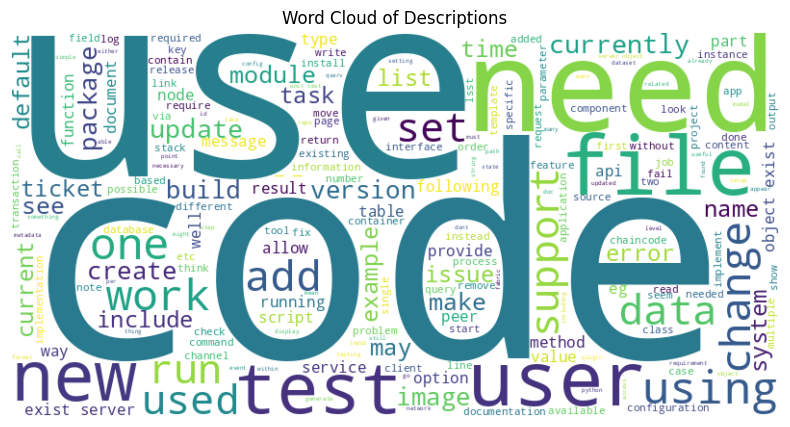

In [76]:
# show word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(all_words))

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Descriptions')
plt.show()

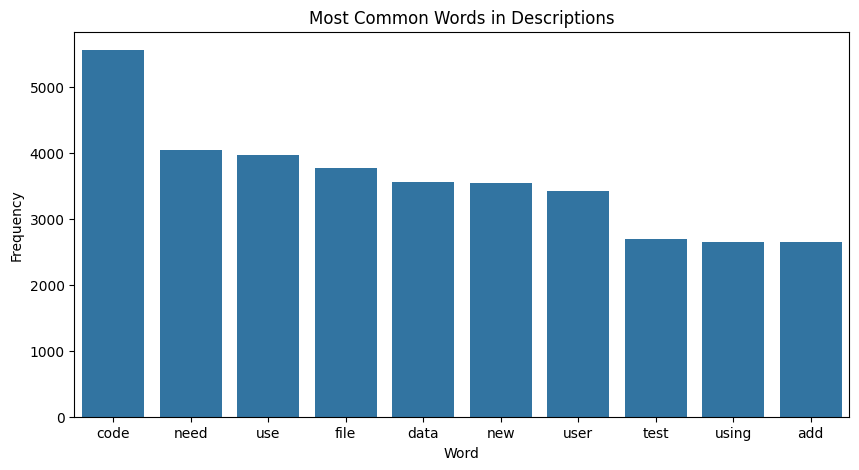

In [77]:
# plot most common words
common_words_df = pd.DataFrame(common_words, columns=['Word', 'Frequency'])

plt.figure(figsize=(10, 5))
sns.barplot(data=common_words_df, x='Word', y='Frequency')
plt.title('Most Common Words in Descriptions')
plt.show()